In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import multiprocessing

%matplotlib inline

np.random.seed(42)

## Perform Preprocessing

In [2]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
y_train = train_data['Survived']
train_data.drop(['Survived', 'Cabin', 'Ticket', 'Name'], axis=1, inplace=True)

In [3]:
#Reset index to PassengerId
train_data.set_index('PassengerId', inplace=True)

In [4]:
#Create list of attributes for preprocessing pipeline
num_attribs = ['Parch', 'Age', 'SibSp', 'Fare']
cat_attribs = ['Pclass', 'Embarked', 'Sex']

In [5]:
#Create pipeline for preprocessing
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("std_scaler", StandardScaler()),   
])

cat_pipeline = Pipeline([
    ("one_hot_encoder", OneHotEncoder()),
    ("imputer", SimpleImputer(strategy="median")),
])

In [6]:
#Create preprocessing pipeline
preprocess_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

X_train = preprocess_pipeline.fit_transform(train_data[num_attribs + cat_attribs])

X_train

array([[-0.47367361, -0.56573646,  0.43279337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47367361,  0.66386103,  0.43279337, ...,  0.        ,
         1.        ,  0.        ],
       [-0.47367361, -0.25833709, -0.4745452 , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 2.00893337, -0.1046374 ,  0.43279337, ...,  0.        ,
         1.        ,  0.        ],
       [-0.47367361, -0.25833709, -0.4745452 , ...,  0.        ,
         0.        ,  1.        ],
       [-0.47367361,  0.20276197, -0.4745452 , ...,  0.        ,
         0.        ,  1.        ]])

_______________________________________________________________________________________________________________________________

## Build Models

In [60]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from multiprocessing import cpu_count

#### SVM Classifier

In [8]:
svm_clf = SVC()

#Train the model
svm_clf.fit(X_train, y_train)

SVC()

In [9]:
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.8226966292134831

In [10]:
svm_clf_report = classification_report(y_train, svm_clf.predict(X_train))
print(svm_clf_report)

              precision    recall  f1-score   support

           0       0.84      0.91      0.87       549
           1       0.83      0.73      0.77       342

    accuracy                           0.84       891
   macro avg       0.83      0.82      0.82       891
weighted avg       0.84      0.84      0.84       891



In [11]:
svm_clf_matrix = confusion_matrix(y_train, svm_clf.predict(X_train))

print(svm_clf_matrix)

[[497  52]
 [ 93 249]]


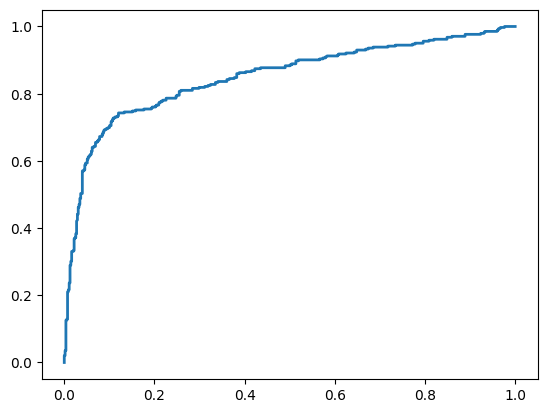

In [12]:
y_scores = cross_val_predict(svm_clf, X_train, y_train, cv=10, method="decision_function")

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

plt.plot(fpr, tpr, linewidth=2)

#### XGBoost Classifier

In [13]:
xgb_clf = XGBClassifier()

#Train the model
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [14]:
#Score the model
xgb_scores = cross_val_score(xgb_clf, X_train, y_train, cv=10)

xgb_scores.mean()

0.8125967540574284

In [15]:
#Classification Report
xgb_clf_report = classification_report(y_train, xgb_clf.predict(X_train))
print(xgb_clf_report)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       549
           1       0.97      0.94      0.95       342

    accuracy                           0.96       891
   macro avg       0.97      0.96      0.96       891
weighted avg       0.96      0.96      0.96       891



In [16]:
#Confusion Matrix
xgb_clf_matrix = confusion_matrix(y_train, xgb_clf.predict(X_train))
print(xgb_clf_matrix)

[[539  10]
 [ 22 320]]


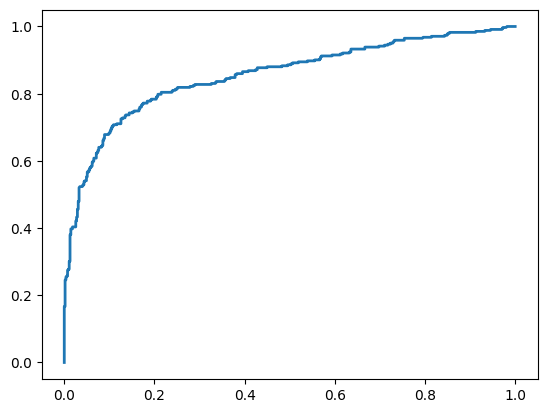

In [17]:
#Display the ROC Curve
y_scores = cross_val_predict(xgb_clf, X_train, y_train, cv=10, method="predict_proba")

fpr, tpr, thresholds = roc_curve(y_train, y_scores[:, 1])

plt.plot(fpr, tpr, linewidth=2)

#### RandomForestClassifier

In [18]:
forest_clf = RandomForestClassifier()

In [19]:
#fit the model
forest_clf.fit(X_train, y_train)

RandomForestClassifier()

In [20]:
#Score the model
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8160049937578027

In [21]:
#Classification Report
forest_clf_report = classification_report(y_train, forest_clf.predict(X_train))
print(forest_clf_report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       549
           1       0.99      0.96      0.97       342

    accuracy                           0.98       891
   macro avg       0.98      0.98      0.98       891
weighted avg       0.98      0.98      0.98       891



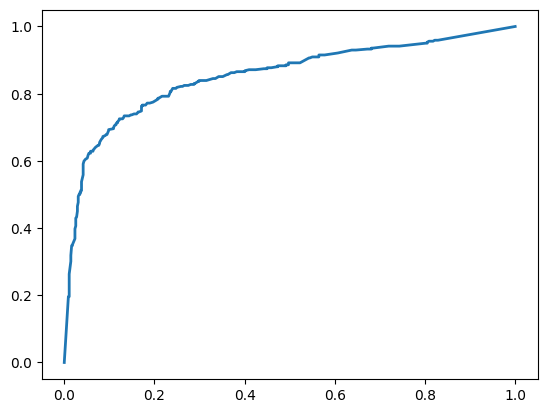

In [22]:
#Display ROC Curve for RandomForestClassifier
y_scores = cross_val_predict(forest_clf, X_train, y_train, cv=10, method="predict_proba")

fpr, tpr, thresholds = roc_curve(y_train, y_scores[:, 1])

plt.plot(fpr, tpr, linewidth=2)

In [23]:
sgd_clf = SGDClassifier()

#fit the model
sgd_clf.fit(X_train, y_train)

SGDClassifier()

In [24]:
#Get classification report
sgd_clf_report = classification_report(y_train, sgd_clf.predict(X_train))
print(sgd_clf_report)

              precision    recall  f1-score   support

           0       0.78      0.85      0.81       549
           1       0.72      0.61      0.66       342

    accuracy                           0.76       891
   macro avg       0.75      0.73      0.74       891
weighted avg       0.76      0.76      0.75       891



In [25]:
#Score the model
sgd_scores = cross_val_score(sgd_clf, X_train, y_train, cv=10)
sgd_scores.mean()

0.7755680399500624

In [26]:
#Create a dictionary of scores for each model
scores_dict = {'RandomForestClassifier': forest_scores.mean(), 'SGDClassifier': sgd_scores.mean(), 'XGBClassifier': xgb_scores.mean(), 'SVC': svm_scores.mean()}
scores_dict

{'RandomForestClassifier': 0.8160049937578027,
 'SGDClassifier': 0.7755680399500624,
 'XGBClassifier': 0.8125967540574284,
 'SVC': 0.8226966292134831}

_______________________________________________________________________________________________________________________________

#### Optimize Models

In [27]:
# #Optimize the RandomForestClassifier for accuracy
# param_grid = [
#     {'n_estimators': [3, 10, 30, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500], 'max_features': [2, 4, 6, 8, 10, 12, 14, 16],
#     'max_leaf_nodes': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]},
# ]

# grid_search = GridSearchCV(forest_clf, param_grid, cv=5, scoring='accuracy', return_train_score=True, n_jobs=multiprocessing.cpu_count())

# grid_search.fit(X_train, y_train)    

In [28]:
# grid_search.best_estimator_

In [29]:
random_forest_clf = RandomForestClassifier(max_features=16, max_leaf_nodes=20, n_estimators=250)

In [30]:
#Fit the classifier
random_forest_clf.fit(X_train, y_train)

RandomForestClassifier(max_features=16, max_leaf_nodes=20, n_estimators=250)

In [31]:
#Get the classification report
random_forest_clf_report = classification_report(y_train, random_forest_clf.predict(X_train))
print(random_forest_clf_report)

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       549
           1       0.91      0.77      0.84       342

    accuracy                           0.88       891
   macro avg       0.89      0.86      0.87       891
weighted avg       0.89      0.88      0.88       891



In [32]:
random_forest_clf_scores = cross_val_score(random_forest_clf, X_train, y_train, cv=10)
random_forest_clf_scores.mean()

0.8317228464419477

In [33]:
# #Optimize the RandomForestClassifier for f1 score
# param_grid = [
#     {'n_estimators': [3, 10, 30, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500], 'max_features': [2, 4, 6, 8, 10, 12, 14, 16],
#     'max_leaf_nodes': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]},
# ]

# grid_search = GridSearchCV(forest_clf, param_grid, cv=10, scoring='f1', return_train_score=True, n_jobs=multiprocessing.cpu_count())

# grid_search.fit(X_train, y_train)

In [34]:
# grid_search.best_estimator_

In [35]:
random_forest_clf_2 = RandomForestClassifier(max_features=12, max_leaf_nodes=18, n_estimators=300)

random_forest_clf_2.fit(X_train, y_train)

RandomForestClassifier(max_features=12, max_leaf_nodes=18, n_estimators=300)

In [36]:
random_forest_clf_2_report = classification_report(y_train, random_forest_clf_2.predict(X_train))
print(random_forest_clf_2_report)

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       549
           1       0.91      0.76      0.83       342

    accuracy                           0.88       891
   macro avg       0.89      0.86      0.87       891
weighted avg       0.88      0.88      0.88       891



In [37]:
random_forest_clf_2_scores = cross_val_score(random_forest_clf_2, 
                                             X_train, 
                                             y_train, 
                                             cv=10)
random_forest_clf_2_scores.mean()

0.8339700374531835

In [38]:
# #Tune XGBoost Classifier
# param_grid = [
#     {'n_estimators': [3, 10, 30, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500], 'max_depth': [2, 4, 6, 8, 10, 12, 14, 16],}]

# grid_search = GridSearchCV(xgb_clf, param_grid, cv=10, scoring='accuracy', return_train_score=True, n_jobs=multiprocessing.cpu_count())

# grid_search.fit(X_train, y_train)

# grid_search.best_estimator_

In [39]:
# grid_search.best_params_

In [40]:
#Create XGBoost Classifier with best parameters
xgb_clf_2 = XGBClassifier(max_depth=12, n_estimators=10)

#Fit the classifier
xgb_clf_2.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [41]:
#Get the classification report
xgb_clf_2_report = classification_report(y_train, xgb_clf_2.predict(X_train))
print(xgb_clf_2_report)

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       549
           1       0.92      0.85      0.88       342

    accuracy                           0.91       891
   macro avg       0.92      0.90      0.91       891
weighted avg       0.91      0.91      0.91       891



In [42]:
#Score the model
xgb_clf_2_scores = cross_val_score(xgb_clf_2, X_train, y_train, cv=10)
xgb_clf_2_scores.mean()

0.8305742821473159

In [43]:
#Compare classification reports for xgb_clf_2 and random_forest_clf_2
print(xgb_clf_2_report)
print(random_forest_clf_2_report)

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       549
           1       0.92      0.85      0.88       342

    accuracy                           0.91       891
   macro avg       0.92      0.90      0.91       891
weighted avg       0.91      0.91      0.91       891

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       549
           1       0.91      0.76      0.83       342

    accuracy                           0.88       891
   macro avg       0.89      0.86      0.87       891
weighted avg       0.88      0.88      0.88       891



In [44]:
gbc = GradientBoostingClassifier()

#Fit the classifier
gbc.fit(X_train, y_train)

GradientBoostingClassifier()

In [45]:
#Get the classification report
gbc_report = classification_report(y_train, gbc.predict(X_train))
print(gbc_report)

              precision    recall  f1-score   support

           0       0.89      0.95      0.91       549
           1       0.90      0.80      0.85       342

    accuracy                           0.89       891
   macro avg       0.89      0.87      0.88       891
weighted avg       0.89      0.89      0.89       891



In [46]:
#Score the model
gbc_scores = cross_val_score(gbc, X_train, y_train, cv=10)
gbc_scores.mean()

0.8294506866416977

In [47]:
param_grid = [
    {'n_estimators': [3, 10, 30, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500], 'max_depth': [2, 4, 6, 8, 10, 12, 14, 16],}]

grid_search = GridSearchCV(gbc, param_grid, cv=10, scoring='accuracy', return_train_score=True, n_jobs=multiprocessing.cpu_count())

grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=GradientBoostingClassifier(), n_jobs=20,
             param_grid=[{'max_depth': [2, 4, 6, 8, 10, 12, 14, 16],
                          'n_estimators': [3, 10, 30, 50, 100, 150, 200, 250,
                                           300, 350, 400, 450, 500]}],
             return_train_score=True, scoring='accuracy')

In [48]:
params = grid_search.best_params_
params

{'max_depth': 2, 'n_estimators': 350}

In [49]:
gbc_2 = GradientBoostingClassifier(max_depth=4, n_estimators=100)

#Fit the classifier
gbc_2.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=4)

In [50]:
#Get the classification report
gbc_2_report = classification_report(y_train, gbc_2.predict(X_train))
print(gbc_2_report)

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       549
           1       0.94      0.87      0.90       342

    accuracy                           0.93       891
   macro avg       0.93      0.92      0.92       891
weighted avg       0.93      0.93      0.93       891



In [51]:
#Score the model
gbc_2_scores = cross_val_score(gbc_2, X_train, y_train, cv=10)
gbc_2_scores.mean()

0.8372908863920101

In [52]:
#Get ROC AUC for gbc_2
roc_auc_gbc_2 = roc_auc_score(y_train, gbc_2.predict(X_train))
print(roc_auc_gbc_2)

0.916355095388745


In [62]:
accuracy = accuracy_score(y_train, gbc_2.predict(X_train))
recall = recall_score(y_train, gbc_2.predict(X_train))
precision = precision_score(y_train, gbc_2.predict(X_train))
print(accuracy, precision, recall)

0.9281705948372615 0.9426751592356688 0.8654970760233918


_________________________________________________________________________________________________________________________________________________

#### Make Predictions

In [53]:
test_data.set_index('PassengerId', inplace=True)

In [54]:
X_test = preprocess_pipeline.transform(test_data[num_attribs + cat_attribs])

In [55]:
X_test.shape

(418, 13)

In [56]:
X_train.shape

(891, 13)

In [57]:
#Make predictions on test set with gbc_2
y_pred = gbc_2.predict(X_test)

y_pred.shape

#Create submission file
submission = pd.DataFrame({'PassengerId': test_data.index, 'Survived': y_pred})

submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [58]:
#Save submission file
# submission.to_csv('submission.csv', index=False)